# Building Blocks 4 RBIG

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

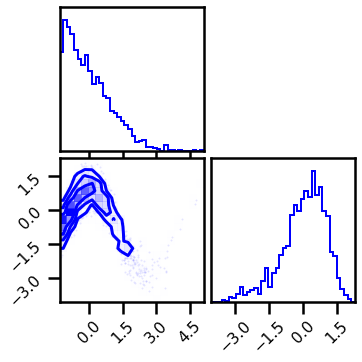

In [3]:
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 2_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [4]:
X = jnp.array(data, dtype=np.float32)

## Model

### Layer I - Univariate Histogram

In [5]:
from rbig_jax.transforms.histogram import InitUniHistTransform, init_bin_estimator
from rbig_jax.transforms.kde import InitUniKDETransform, estimate_bw

# support_extension = 10
# alpha = 1e-5
# precision = 100
# nbins = None #init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
# jitted = True

# # initialize histogram transformation
# init_hist_f = InitUniHistTransform(
#     n_samples=X.shape[0],
#     nbins=nbins,
#     support_extension=support_extension,
#     precision=precision,
#     alpha=alpha,
#     jitted=jitted
# )

# KDE Transform
support_extension = 20
alpha = 1e-5
precision = 1_000
bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")

init_hist_f = InitUniKDETransform(
    shape=X.shape, support_extension=support_extension, precision=precision, bw=bw
)

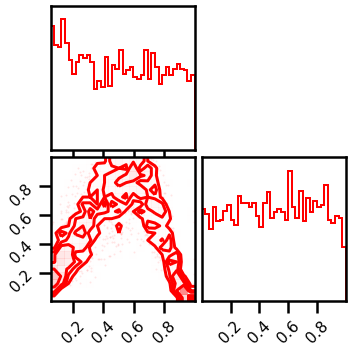

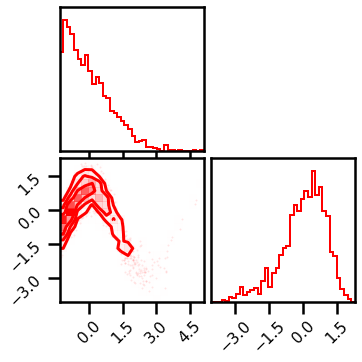

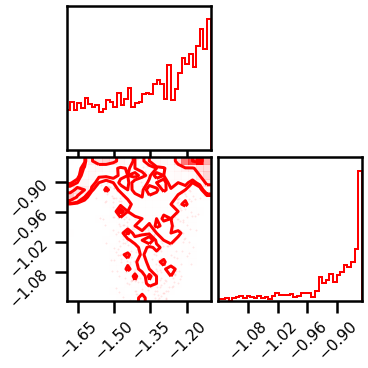

In [6]:
# initialize bijector
X_u, hist_bijector = init_hist_f.init_bijector(X)

# forward transformation
X_l1 = hist_bijector.forward(X)

# inverse transformation
X_approx = hist_bijector.inverse(X_l1)

# gradient transformation
X_l1_ldj = hist_bijector.forward_log_det_jacobian(X_l1)

# plot Transformations
fig = corner.corner(X_l1, color="red", hist_bin_factor=2)
fig = corner.corner(X_approx, color="red", hist_bin_factor=2)
fig = corner.corner(X_l1_ldj, color="red", hist_bin_factor=2)

### Layer II - Inverse Gaussian CDF

In [7]:
from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# univariate normalization Gaussianization parameters
eps = 1e-5

# initialize histogram transformation
init_icdf_f = InitInverseGaussCDFTransform(eps=eps)

In [8]:
X_l2, icdf_bijector = init_icdf_f.init_bijector(X_l1)
X_l2_ = icdf_bijector.forward(X_l1)
X_l1_approx = icdf_bijector.inverse(X_l2)
X_l2_ldj = icdf_bijector.forward_log_det_jacobian(X_l1)

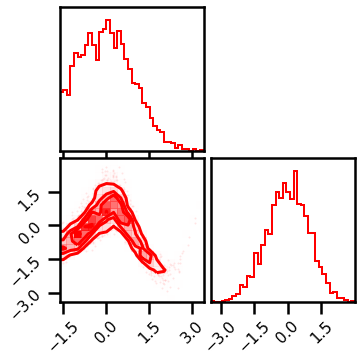

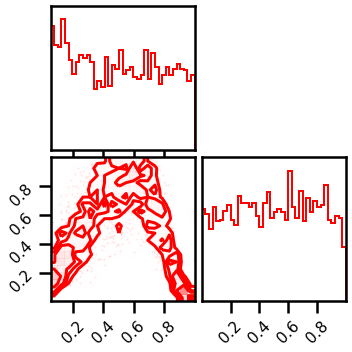

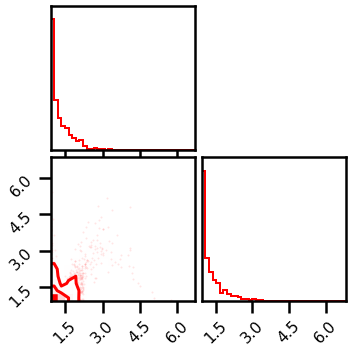

In [9]:
# plot Transformations
fig = corner.corner(X_l2, color="red", hist_bin_factor=2)
fig = corner.corner(X_l1_approx, color="red", hist_bin_factor=2)
fig = corner.corner(X_l2_ldj, color="red", hist_bin_factor=2)

### PCA Transformation

In [10]:
from rbig_jax.transforms.rotation import InitPCARotation

In [11]:
# initialize histogram transformation
init_pca_f = InitPCARotation(jitted=True)

In [12]:
# init and forward transform
X_l3, pca_bijector = init_pca_f.init_bijector(X_l2)

# forward transformation
X_l3_ = jax.jit(pca_bijector.forward)(X_l2)

# inverse transformation
X_l2_approx = pca_bijector.inverse(X_l3)

X_l3_ldj = pca_bijector.forward_log_det_jacobian(X_l2)

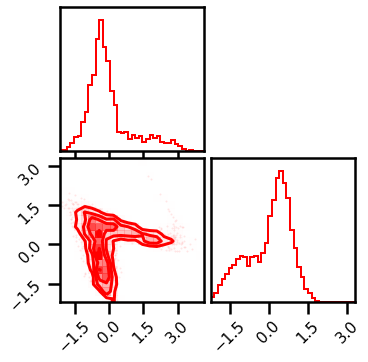

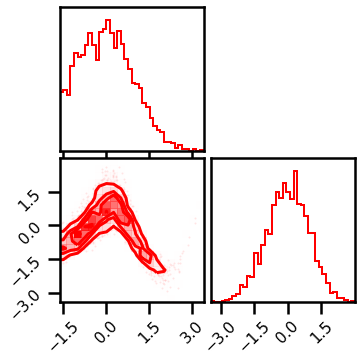

In [13]:
# plot Transformations
fig = corner.corner(X_l3, color="red", hist_bin_factor=2)
fig = corner.corner(X_l2_approx, color="red", hist_bin_factor=2)

## RBIG Blocks

1. Marginal Gaussianization
2. Random Rotation

In [14]:
from rbig_jax.transforms.block import RBIGBlock

In [15]:
init_functions = [init_hist_f, init_icdf_f, init_pca_f]

rbig_block = RBIGBlock(init_functions=init_functions)

In [16]:
X_g, bijectors = rbig_block.forward_and_params(X)

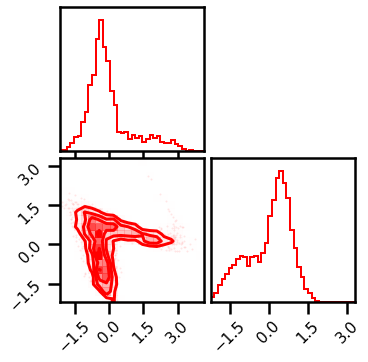

In [17]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

### Forward + Inverse Transformation

In [18]:
from rbig_jax.transforms.base import BijectorChain

In [19]:
X_approx.shape, X.shape, type(X_approx), type(X)

((2000, 2),
 (2000, 2),
 jaxlib.xla_extension.DeviceArray,
 jaxlib.xla_extension.DeviceArray)

In [20]:
b = BijectorChain(bijectors=bijectors)

In [21]:
# forward cascade
X_g_, _ = BijectorChain(bijectors=bijectors).forward_and_log_det(X)

chex.assert_tree_all_close(X_g, X_g_, rtol=1e-4)

# inverse cascade
X_approx, _ = BijectorChain(bijectors=bijectors).inverse_and_log_det(X_g)

# chex.assert_tree_all_close(X_approx, X, rtol=1e-4)

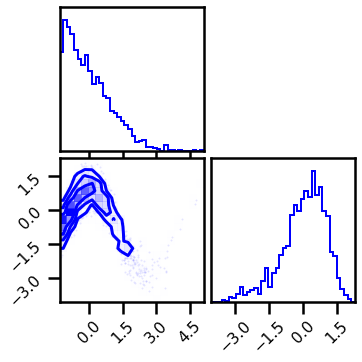

In [22]:
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

## Multiple Layers

CPU times: user 7.37 s, sys: 2.1 s, total: 9.47 s
Wall time: 4.37 s


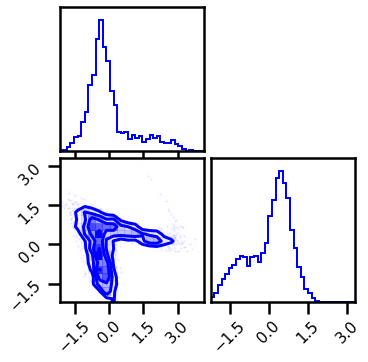

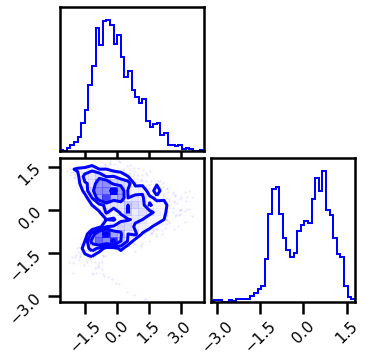

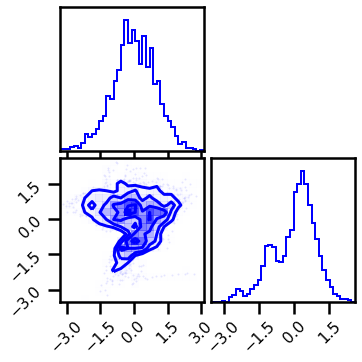

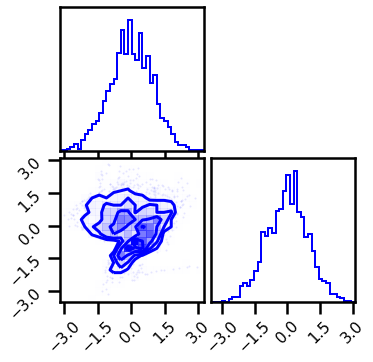

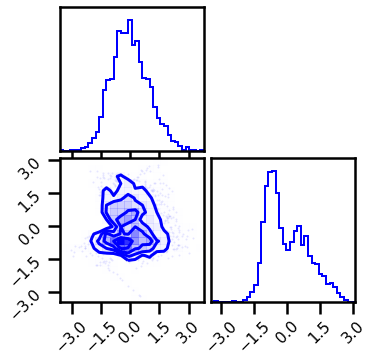

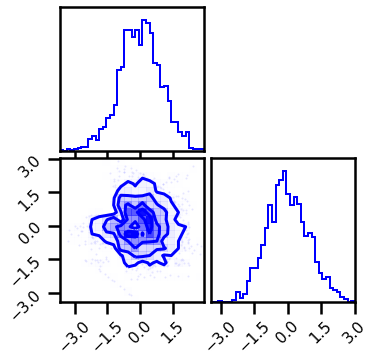

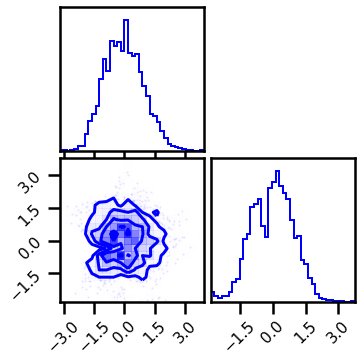

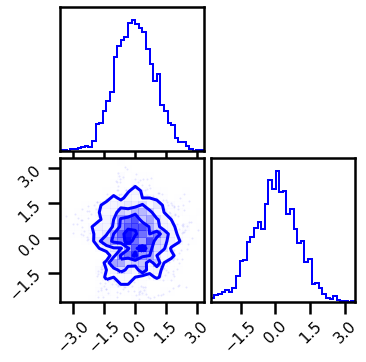

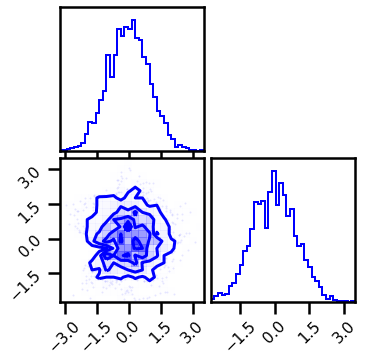

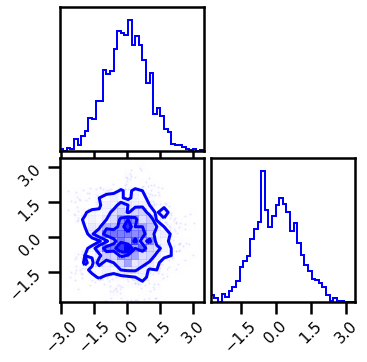

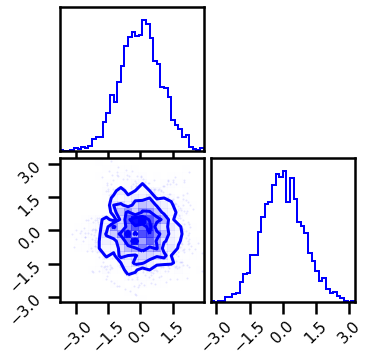

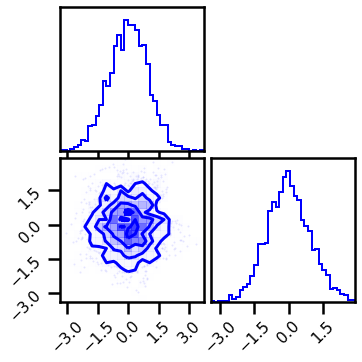

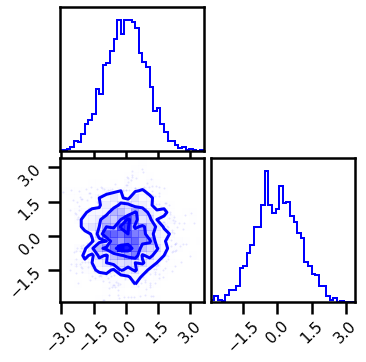

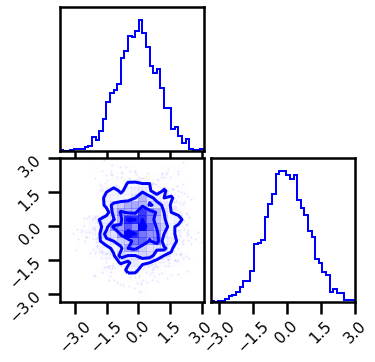

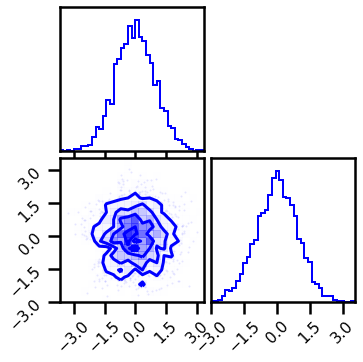

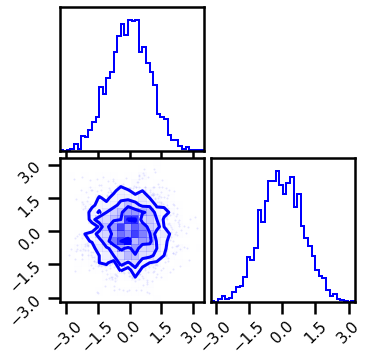

In [23]:
%%time

import itertools

itercount = itertools.count(-1)

n_layers = 15
i_layer = 0

# initialize rbig block
init_functions = [
    init_hist_f,
    init_icdf_f,
    init_pca_f
]

rbig_block = RBIGBlock(init_functions=init_functions)

bijectors = list()
# initialize transform
X_g = X.copy()

while next(itercount) < n_layers:
    
    # fit RBIG block
    X_g, ibijector = rbig_block.forward_and_params(X_g)
    
    fig = corner.corner(X_g, color="blue", hist_bin_factor=2)
    
    # append bijectors 
    bijectors += ibijector

#### Check Transformation

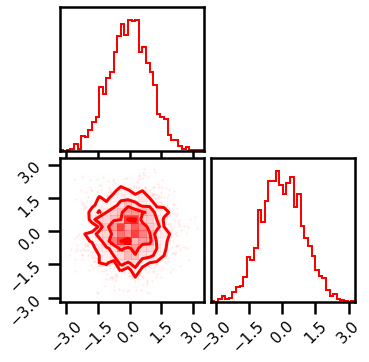

In [24]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

In [39]:
from chex import dataclass, Array
from dataclasses import field

In [43]:
from typing import NamedTuple


class Temp(NamedTuple):
    x: Array = field(default=None)

In [45]:
t = Temp()
t

Temp(x=Field(name=None,type=None,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7f3329a2cd90>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=None))

In [25]:
from rbig_jax.models import GaussianizationFlow

In [26]:
from distrax._src.distributions.normal import Normal

# initialize base distribution
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

rbig_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)

### Transformations

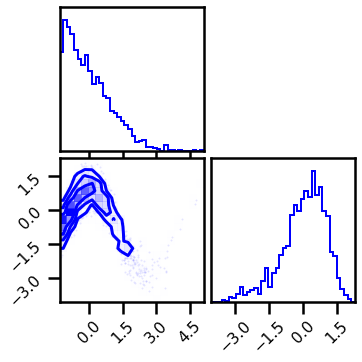

In [27]:
# inverse cascade
X_approx = rbig_model.inverse(X_g)

# plot
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

### Probability Density

In [28]:
from rbig_jax.data import generate_2d_grid

    
```python
# propagate through the chain
X_g_grid, X_ldj_grid = rbig_model.forward_and_log_det(xyinput)

# calculate log prob
base_dist = Normal(jnp.zeros((2,)), jnp.ones((2,)))

latent_prob = base_dist.log_prob(X_g_grid)

# calculate log probability
X_log_prob = latent_prob.sum(axis=1) + X_ldj_grid.sum(axis=1)
```

In [29]:
%%time

# generate inputs
xyinput = generate_2d_grid(X, 200, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 4.2 s, sys: 334 ms, total: 4.53 s
Wall time: 3.22 s


In [ ]:
# Original Density
n_samples = 1_000_000
n_features = 2
X_plot = get_classic(n_samples, seed=123)
X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)



cmap = cm.magma # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12,5))
h = ax[0].hist2d(X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0., vmax=1.)
ax[0].set_title("True Density")
ax[0].set(xlim=[X_plot[:, 0].min(), X_plot[:,0].max()], ylim=[X_plot[:,1].min(), X_plot[:,1].max()])

h1 = ax[1].scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0)
ax[1].set(xlim=[xyinput[:, 0].min(), xyinput[:,0].max()], ylim=[xyinput[:,1].min(), xyinput[:,1].max()])
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

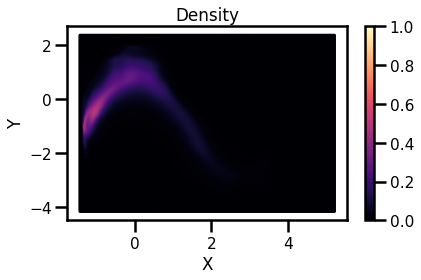

In [30]:
from matplotlib import cm

cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
title = "Density"

fig, ax = plt.subplots()
h = ax.scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.show()

### Sampling

In [31]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)


# # generate Gaussian samples
# X_g_samples = base_dist.sample(seed=123, sample_shape=(10_000))

# # # inverse transformation
# X_samples = rbig_model.inverse(X_g_samples)

CPU times: user 3.27 s, sys: 212 ms, total: 3.48 s
Wall time: 2.03 s


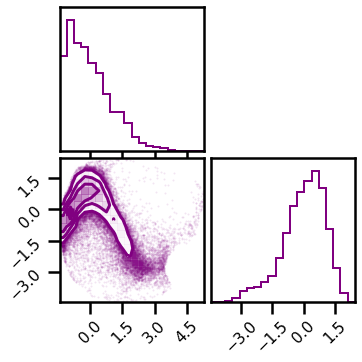

In [32]:
fig = corner.corner(X_samples, color="purple")

In [33]:
rbig_model.score(X)

DeviceArray(1.9235227, dtype=float32)